# Import Modules

In [20]:
import json

import numpy as np
import pandas as pd
import torch

import utils

# Set Vegetable

In [22]:
vegetable = utils.VEGETABLES[7]

json_open = open('./free_params.json', 'r')
params = json.load(json_open)
param = params[vegetable]

print(f"vegetable: {vegetable}")
print(f"free params: {param}")

vegetable: ねぎ
free params: {'T': 10, 'batch_size': 16, 'num_epochs': 150, 'learning_rate': 0.001, 'weight_decay': 0.001, 'eps': 1e-08, 'hidden_size': 1000, 'dropout_ratio': 0.5, 'num_ensamble': 5}


# Load Data

In [23]:
train_test = pd.read_csv("./data/mapped_train_test.csv")
train_test["date"] = pd.to_datetime(train_test["date"], format="%Y-%m-%d")
weather = pd.read_csv("./data/sorted_mapped_adjusted_weather.csv")
train_test = pd.concat([train_test, weather], axis=1)
train_test = train_test.reset_index(drop=True)

train_test["year"] = train_test.date.dt.year
years = pd.get_dummies(train_test["year"])
train_test = train_test.drop(columns="year")
train_test = pd.concat([train_test, years], axis=1)

train_test["month"] = train_test.date.dt.month
months = pd.get_dummies(train_test["month"])
train_test = train_test.drop(columns="month")
train_test = pd.concat([train_test, months], axis=1)

areas = pd.get_dummies(train_test["area"])
train_test = train_test.drop(columns="area")
train_test = pd.concat([train_test, areas], axis=1)

test_size = pd.read_csv("./data/test.csv").shape[0]
train = train_test[:-test_size]
test = train_test[-test_size:]

train = utils.get_target_values(train, vegetable)
test = utils.get_target_values(test, vegetable)

changed_col = [1, 0] + [i for i in np.arange(2, train.shape[1])]
train = train[:, changed_col]
test = test[:, changed_col]

test_amount = pd.read_csv("./data/test_amount.csv")
test_amount = test_amount[vegetable].values
test[:, 1] = test_amount

train_loader, train, test, ss = utils.preprocess_data_mto1(train, test, T=param["T"], batch_size=param["batch_size"])

In [24]:
for _, (batch_x, batch_y) in enumerate(train_loader):
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([16, 10, 279])
torch.Size([16, 1])


# Assign Free Params

In [25]:
future = test.shape[0]
num_ensamble = param["num_ensamble"]
num_epochs = param["num_epochs"]
learning_rate = param["learning_rate"]
weight_decay = param["weight_decay"]
eps = param["eps"]
hidden_size = param["hidden_size"]
dropout_ratio = param["dropout_ratio"]

# Training

In [26]:
models = []
for _ in range(num_ensamble):
    
    model = utils.pipeline_rnn_submit(train_loader, train, test, future=future, num_epochs=num_epochs, lr=learning_rate,
                                      weight_decay=weight_decay, eps=eps, hidden_size=hidden_size, dropout_ratio=dropout_ratio)
    models.append(model)

# Predict

In [27]:
preds = []
test_np = test.cpu().detach().numpy()
for model in models:
    with torch.no_grad():
        model.eval()
        pred_y = model.predict(train, test, future)

    pred_y = pred_y.cpu().detach().numpy()
    
    pred_y = np.concatenate([pred_y.reshape(-1, 1), test_np[:, 1:]], axis=1)
    pred_y[:, :7] = ss.inverse_transform(pred_y[:, :7])
    pred_y = pred_y[:, 0].tolist()

    preds.append(pred_y)

pred_y = np.mean(np.array(preds),axis=0)

In [33]:
pred_y = np.mean(np.array(preds),axis=0)

In [28]:
pred_y.tolist()

[1714.5527587890624,
 1770.4857666015625,
 1683.5466796875,
 1532.7705810546875,
 1509.991650390625,
 1561.3765380859375,
 1573.53525390625,
 1521.6934326171875,
 1612.1877197265626,
 1709.6316650390625,
 1779.03017578125,
 1810.5008544921875,
 1766.024169921875,
 1752.9901123046875,
 1757.4171630859375,
 1776.65830078125,
 1769.203759765625,
 1683.53427734375,
 1764.538525390625,
 1752.4733154296875]

In [36]:
test_y

array([1728, 1620, 1728, 1728, 1620, 1728, 1728, 1836, 1728, 1836, 1944,
       2160, 2160, 2376, 2268, 2484, 2376, 2376, 2160, 2268])

In [34]:
prev = [1170.446558,
1140.184961,
1050.051245,
1066.856372,
1084.071191,
1126.003247,
1110.306006,
1125.573413,
1126.034961,
1102.569141,
1112.0698,
1072.164355,
1099.573096,
1117.732007,
1095.651978,
1091.448657,
1052.976404,
1067.212671,
1077.097998,
1054.890796]

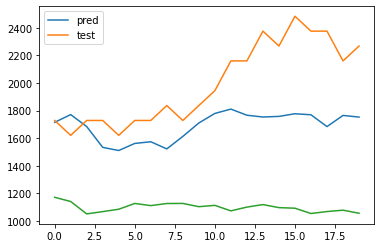

In [35]:
df = pd.read_csv("./data/test_ans.csv")
df["date"] = df["Unnamed: 0"]
df = df.drop(columns="Unnamed: 0")
df = df.set_index("date")
test_y = df[vegetable].values

import matplotlib.pyplot as plt
plt.plot(pred_y, label="pred")
plt.plot(test_y, label="test")
plt.plot(prev)
plt.legend()

In [30]:
def RMSPE(pred_y, test_y):
    ans = []
    for pred, test in zip(pred_y, test_y):
        ans.append((pred-test) / test)
    ans = np.sum(ans)
    ans = ((ans**2)/len(pred_y)) * 100
    print(f"RMSPE:{ans}")
    return ans

In [31]:
RMSPE(pred_y, test_y)

RMSPE:38.440100229958915


38.440100229958915